## 序列模型
#### 使用正弦函数和一些可加性噪声来生成序列数据，时间步为1，2，...，1000

In [32]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

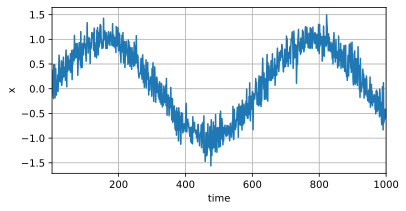

In [33]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

## 利用马尔科夫假设，生成数据对

In [34]:
# 当前时刻的观测值只与前面四个时刻的观测值相关
tau = 4
# 第一行为0,1,2,3时刻的观测值，labels第一行为4时刻的观测值
# 第二行为1,2,3,4时刻的观测值，labels第二行为5时刻的观测值
# 以此类推......
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

## 使用一个相当简单的结构：只是使用一个拥有两个全连接层的多层感知机

In [35]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

In [38]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, 10, 0.5)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        scheduler.step()
        print(f'epoch {epoch + 1}', f'loss: {d2l.evaluate_loss(net, train_iter, loss)}')

net = get_net()
train(net, train_iter, loss, 100, 0.1)

epoch 1 loss: 0.04783528410878621
epoch 2 loss: 0.06340673673701913
epoch 3 loss: 0.06478983340294737
epoch 4 loss: 0.05010578847539268
epoch 5 loss: 0.0707285424302283
epoch 6 loss: 0.05437213422632531
epoch 7 loss: 0.05082090591129504
epoch 8 loss: 0.04581858433390919
epoch 9 loss: 0.0871079801336715
epoch 10 loss: 0.09961860656346146
epoch 11 loss: 0.0514174888498689
epoch 12 loss: 0.049831177206023744
epoch 13 loss: 0.047964550162616526
epoch 14 loss: 0.04790016195099605
epoch 15 loss: 0.04586898932527555
epoch 16 loss: 0.04864289371394798
epoch 17 loss: 0.05037876051899634
epoch 18 loss: 0.04665812710300088
epoch 19 loss: 0.04620587600297049
epoch 20 loss: 0.06113760388995472
epoch 21 loss: 0.04968342160511958
epoch 22 loss: 0.04816435723516502
epoch 23 loss: 0.046666636131703854
epoch 24 loss: 0.04460522954009081
epoch 25 loss: 0.04958715196698904
epoch 26 loss: 0.048090530559420586
epoch 27 loss: 0.0460605821817329
epoch 28 loss: 0.04583945279744895
epoch 29 loss: 0.045697742729

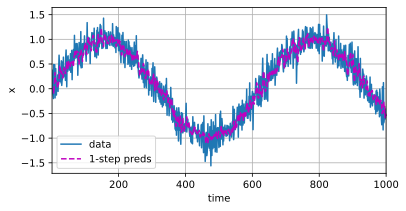

In [40]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()],
         'time', 'x', legend=['data', '1-step preds'],
         xlim=[1, 1000], figsize=(6, 3))

## 进行多步预测

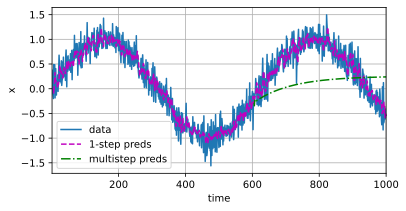

In [41]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

# 从600往后预测400个点，错的有点离谱
# 每一次预测的误差不断累积
# 短期预测还行

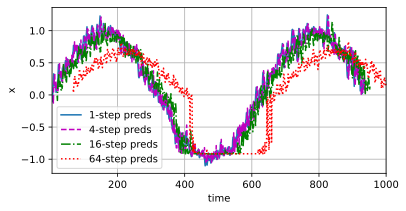

In [42]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))